inspect source code 

In [ ]:
import torch

# 原始 Stable Diffusion v2.1 的完整 ckpt 路径
full_ckpt_path = "ckpt/v2-1_512-ema-pruned.ckpt"

# 新的只包含 diffusion 模型的 ckpt 输出路径
output_unet_ckpt_path = "ckpt/unet_only.ckpt"

# 加载完整 checkpoint（不自动加载到模型，只读字典）
ckpt = torch.load(full_ckpt_path, map_location="cpu")

# 提取 diffusion_model（即 UNet）的部分
full_state_dict = ckpt["state_dict"]
unet_state_dict = {
    k.replace("model.diffusion_model.", ""): v
    for k, v in full_state_dict.items()
    if k.startswith("model.diffusion_model.")
}

# 包装成符合 StableSR 加载格式的 state_dict
new_ckpt = {
    "state_dict": {
        "model.diffusion_model." + k: v for k, v in unet_state_dict.items()
    }
}

# 保存
torch.save(new_ckpt, output_unet_ckpt_path)
print(f"Saved diffusion UNet-only checkpoint to: {output_unet_ckpt_path}")


In [ ]:
import os
with open("model.diffusion.model.txt", "w") as f:
    for key in ckpt["state_dict"].keys():
        if key.startswith("model.diffusion_model."):
            f.write(f"{str(key)}\n")

In [ ]:
def check_shape(sr_path):
    import os 
    import numpy as np
    imgs=os.listdir(sr_path)
    img_path=os.path.join(sr_path, imgs[0])
    img=np.load(img_path)
    print(img.shape)
    print(img.dtype)
    print(type(img))

check_shape("/mnt/data/wavelet5_full_64_512/hr_512")
check_shape("/mnt/data/wavelet5_full_64_512/hr_512")

In [ ]:
from ldm.models.diffusion.ddpm import DDPM
DDPM?

In [ ]:
def summarize_class(cls):
    import inspect
    print(f"## Class: {cls.__name__}\n")

    bases = ', '.join(base.__name__ for base in cls.__bases__)
    print(f"## Inherits from: {bases}\n")

    print("## 📦 Attributes (class-level):")
    for name, value in vars(cls).items():
        if not name.startswith("__") and not callable(value):
            print(f"- {name} = {value}")
    
    print("\n## 🧩 Methods:")
    for name, obj in inspect.getmembers(cls, predicate=inspect.isfunction):
        if not name.startswith("_"):
            print(f"- `{name}{inspect.signature(obj)}`")


In [ ]:
summarize_class(DDPM)

In [ ]:
import inspect
from ldm.models.diffusion.ddpm import DDPM

def get_own_methods(cls):
    return [
        (name, func)
        for name, func in inspect.getmembers(cls, predicate=inspect.isfunction)
        if func.__qualname__.startswith(cls.__name__)
    ]

print(f"## Methods defined in {DDPM.__name__}:")
for name, func in get_own_methods(DDPM):
    print(f"[[{name}{inspect.signature(func)}]]")


In [ ]:
import inspect

def analyze_class_structure(cls):
    print(f"# Class: {cls.__name__}")
    print("## 📚 Inheritance Tree (MRO):")
    for base in cls.__mro__:
        print(f"- {base.__name__}")
    print("\n## 📦 Attributes (with origin):")
    for name, val in inspect.getmembers(cls):
        if not callable(val) and not name.startswith("__"):
            owner = find_defining_class(cls, name)
            print(f"- `{name}`  ←  from `{owner.__name__}`")

    print("\n## 🧩 Methods (with origin):")
    for name, func in inspect.getmembers(cls, predicate=inspect.isfunction):
        owner = find_defining_class(cls, name)
        print(f"- `{name}{inspect.signature(func)}`  ←  from `{owner.__name__}`")


def find_defining_class(cls, attr):
    """Find the class in MRO that first defines attr"""
    for base in cls.__mro__:
        if attr in base.__dict__:
            return base
    return object


In [ ]:
analyze_class_structure(DDPM)

In [ ]:
import inspect
import os
import sys
import ast, inspect
from collections import defaultdict

def is_third_party(obj):
    try:
        path = inspect.getfile(obj)
        stdlib = sys.prefix
        return any((
            "site-packages" in path,
            "torch" in path,
            "pytorch_lightning" in path,
            path.startswith(stdlib)  # 标准库
        ))
    except TypeError:
        return True  # C 编译的内建对象视为第三方

def find_defining_class(cls, attr):
    for base in cls.__mro__:
        if attr in base.__dict__:
            return base
    return object

def get_self_assignments_from_class_ast(cls):
    props_to_methods = defaultdict(list)

    try:
        source_file = inspect.getsourcefile(cls)
        if not source_file:
            return props_to_methods

        with open(source_file, "r", encoding="utf-8") as f:
            source = f.read()

        tree = ast.parse(source)

        # 找到类定义
        for node in tree.body:
            if isinstance(node, ast.ClassDef) and node.name == cls.__name__:
                for func in node.body:
                    if isinstance(func, ast.FunctionDef):
                        method_name = func.name
                        for stmt in ast.walk(func):
                            if isinstance(stmt, ast.Assign):
                                for target in stmt.targets:
                                    if (
                                        isinstance(target, ast.Attribute)
                                        and isinstance(target.value, ast.Name)
                                        and target.value.id == "self"
                                    ):
                                        props_to_methods[target.attr].append(method_name)
        return props_to_methods

    except Exception as e:
        print(f"Failed to analyze class {cls.__name__}: {e}")
        return props_to_methods

def analyze_class_structure(cls):
    print(f"## Class: {cls.__name__}")
    print("## Inheritance Tree (MRO):")
    for base in cls.__mro__:
        print(f"- {base.__name__}")

    print("\n## Instance Attributes (from self.xxx assignments):")
    props = get_self_assignments_from_class_ast(cls)
    for attr, defined_in in props.items():
        print(f"- {attr} (defined in: [[{', '.join(defined_in)}]])")

    print("\n## Project-defined Methods:")
    for name, func in inspect.getmembers(cls, predicate=inspect.isfunction):
        owner = find_defining_class(cls, name)
        if not is_third_party(func):
            print(f"- [[{name}]]  ←  [[{owner.__name__}]]")

    print("\n## Project-defined Attributes:")
    for name, val in inspect.getmembers(cls):
        if not callable(val) and not name.startswith("__"):
            owner = find_defining_class(cls, name)
            if not is_third_party(val):
                print(f"- {name}  ←  [[{owner.__name__}]]")




In [ ]:
analyze_class_structure(DDPM)

## debug log_images

In [1]:
import torch
print(torch.cuda.device_count())    # 输出有几张卡


/home/flyingbucket/miniconda3/envs/stablesr/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4


In [5]:
import torch
from omegaconf import OmegaConf
from ldm.models.diffusion.ddpm_wavelet import LatentDiffusionWaveletCS
from ldm.models.diffusion.ddpm_ori_so import LatentDiffusionOriSO
from main import ImageLogger
B, C, H, W = 2, 1, 512, 512
dummy_batch = {
    "lq_image": torch.randn(B, C, H, W),
    "gt_image": torch.randn(B, C, H, W),
    "wavelet": torch.randn(B, 4, H, W)
}
config_path = "configs/stableSRNew/wavelet_klz16emb16_so.yaml"
config = OmegaConf.load(config_path)
model = LatentDiffusionWaveletCS(**config.model.params)

ckpt_path = config.model.params.get("ckpt_path", None)
ckpt_path="logs/2025-07-24T18-46-23_W_KL_z16emb16_SO/checkpoints/last.ckpt"
model.init_from_ckpt(ckpt_path)

model.eval()
if torch.cuda.is_available():
    device = torch.device("cuda:3")
else:
    device = torch.device("cpu")
model = model.to(device)
# model = model.to("cuda" if torch.cuda.is_available() else "cpu")


[DEBUG] ddpm init ckpt_path: None
LatentDiffusionWaveletCS: Running in eps-prediction mode
DiffusionWrapper has 695.01 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 16, 64, 64) = 65536 dimensions.
making attention of type 'vanilla' with 512 in_channels
[AutoIgnore] Will skip key: model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_k.weight
[AutoIgnore] Will skip key: model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_k.weight
[AutoIgnore] Will skip key: model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_k.weight
[AutoIgnore] Will skip key: model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_k.weight
[AutoIgnore] Will skip key: model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_k.weight
[AutoIgnore] Will skip key: model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_k.weight
[AutoIgnore] Will skip key: model.diffusion_model.middle_block.

In [6]:
model.model.conditioning_key

'struct_only'

In [7]:
import os
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from basicsr.data.wavelet_dataset import WaveletSRDataset
import matplotlib.pyplot as plt 
import cv2
from ldm.util import instantiate_from_config
from omegaconf import OmegaConf
from ldm.models.diffusion.ddpm_wavelet import LatentDiffusionWaveletCS
from ldm.models.diffusion.ddpm_ori_so import LatentDiffusionOriSO

# === 3. 加载一个样本 batch ===
# dataset = WaveletSRDataset(split="val")  # 👈 自己的数据集类
# config_path = "configs/stableSRNew/wavelet_so.yaml"
# config_path="configs/autoencoder/autoencoderKL_64.yaml"
# config = OmegaConf.load(config_path)
data_params=config.data.params.validation.params
dataset = WaveletSRDataset(data_params, split="val")  # 👈 直接传 params！推荐 ✅
data = instantiate_from_config(config.data)
data.setup()
dataloader = data.val_dataloader()

batch = next(iter(dataloader))
print(batch['gt_path'][0])

/home/flyingbucket/DataStore/WHU_512_small/NH49E001013.tif_0_12.png


In [8]:
# dataloader = DataLoader(dataset, batch_size=2, shuffle=False, num_workers=2)
batch = next(iter(dataloader))

batch = {
    k: (v.to(device) if torch.is_tensor(v) else v)
    for k, v in batch.items()
}
# === 4. 调试 log_images ===
log = model.log_images(batch, sample=True, plot_diffusion_rows=False, plot_progressive_rows=False)
print(f"[INFO] log_images keys: {list(log.keys())}")

os.makedirs("debug_out", exist_ok=True)
n_kind=len(log.keys())


[INFO] log_images keys: ['input_hq', 'recon_hq', 'input_lq', 'recon_lq', 'samples']


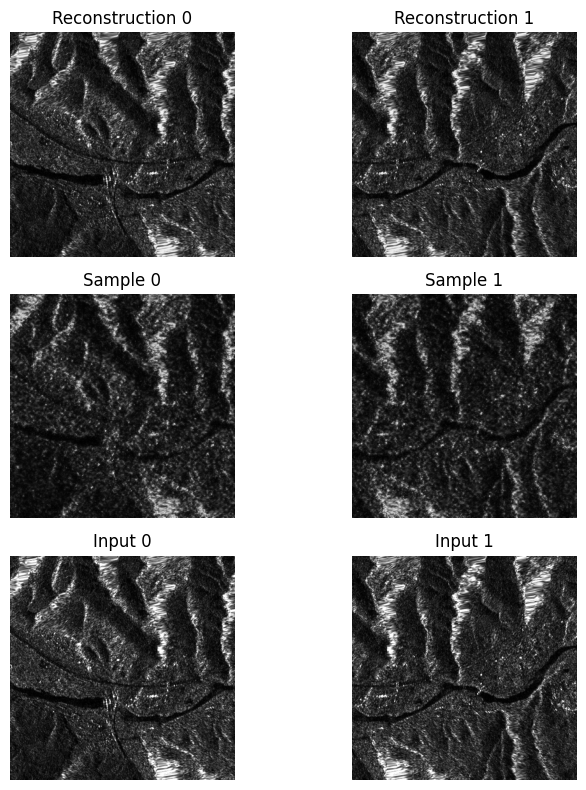

In [9]:

recons_hq = log["recon_hq"].detach().cpu()  # [B, 1, H, W]
samples = log["samples"].detach().cpu()        # [B, 1, H, W]
inputs= log["input_hq"].detach().cpu()          # [B, 1, H, W]
# 展示每张图
n = recons_hq.shape[0]  # batch size

fig, axs = plt.subplots(nrows=3, ncols=n, figsize=(4 * n, 8))

for i in range(n):
    # 去掉 channel 维度，转为 (H, W)
    recon_img = recons_hq[i, 0]
    sample_img = samples[i, 0]

    axs[0, i].imshow(recon_img, cmap='gray')
    axs[0, i].set_title(f"Reconstruction {i}")
    axs[0, i].axis('off')

    axs[1, i].imshow(sample_img, cmap='gray')
    axs[1, i].set_title(f"Sample {i}")
    axs[1, i].axis('off')

    axs[2, i].imshow(inputs[i, 0], cmap='gray')
    axs[2, i].set_title(f"Input {i}")
    axs[2, i].axis('off')
plt.tight_layout()
plt.show()

# # === 5. 保存图像结果 ===
# save("inputs")
# save("reconstruction")
# save("samples")
# save("samples_x0_quantized")
# save("samples_inpainting")
# save("samples_outpainting")
# save("diffusion_row")
# save("progressive_row")
# save("denoise_row")
# save("mask")


In [11]:
inputs=inputs.to(device)
with torch.no_grad():
    posterior = model.encode_first_stage(inputs)
    z = posterior.sample()  # 从分布中采样latent
    xrec_direct = model.decode_first_stage(z)



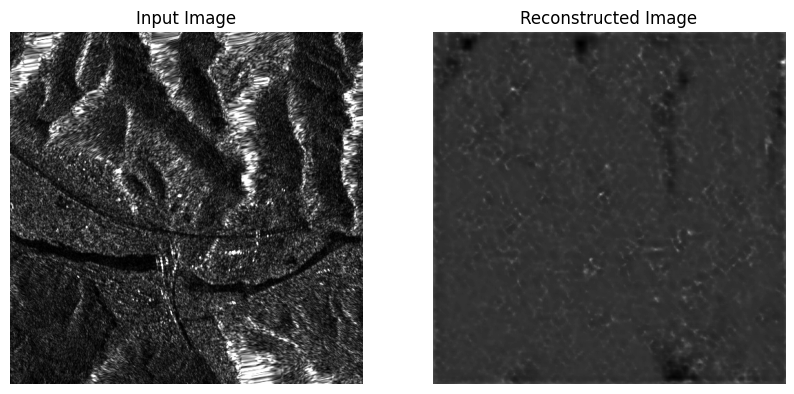

In [12]:
figure,axs=plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].imshow(inputs[0, 0].cpu().numpy(), cmap='gray')
axs[0].set_title("Input Image")
axs[0].axis('off')
axs[1].imshow(xrec_direct[0, 0].cpu().numpy(), cmap='gray')
axs[1].set_title("Reconstructed Image")
axs[1].axis('off')
plt.show()
# for i in range(inputs.shape[0]):
#     input_img = inputs[i, 0].cpu().numpy()
#     recon_img = xrec_direct[i, 0].cpu().numpy()


In [ ]:
for key in log:
    print(key,log[key].shape, log[key].dtype, type(log[key]))

In [ ]:
import torch
ckpt_path="logs/2025-07-10T16-25-18_w/checkpoints/last.ckpt"
model=torch.load(ckpt_path, map_location="cpu")
model.keys()

In [ ]:
model["state_dict"].keys()

In [ ]:
img_dir="logs/2025-07-12T12-41-35_AutoencoderKL_no_GAN/images/train"
import matplotlib.pyplot as plt
import os

# def normalize(img):
#     return (img - img.min()) / (img.max() - img.min() + 1e-5)
def normalize(img):
    img = img.astype('float32')
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return img

def show_images_from_dir(img_dir, n=4):
    img_files = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    img_files = img_files[:n]  # 只取前 n 张

    fig, axs = plt.subplots(1, n, figsize=(4 * n, 4))
    for i, img_file in enumerate(img_files):
        img_path = os.path.join(img_dir, img_file)
        img = plt.imread(img_path)
        img = normalize(img) if img.ndim == 2 else img
        axs[i].imshow(img,cmap='gray')
        axs[i].set_title(f"Image {i+1}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

show_images_from_dir(img_dir, n=4)

In [ ]:
import cv2 
def show_gray(image, title="Image"):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()
# img_dir2="logs/2025-07-10T16-25-18_w/images/train"
# sample_imgs=[s_img for s_img in os.listdir(img_dir2) if s_img.startswith("sample")]
img_dir3="logs/2025-07-12T16-49-55_WKL_CS0/images/train"
img_dir="logs/2025-07-12T12-15-10_AutoencoderKL/images/train"
for img in sorted(os.listdir(img_dir)):
    img_path = os.path.join(img_dir, img)
    if img.endswith(('.png', '.jpg', '.jpeg')):
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            print(f"Image: {img}, Shape: {image.shape}, Dtype: {image.dtype}, Type: {type(image)}")
            show_gray(image, title=img)
        else:
            print(f"Failed to read image: {img}")

In [ ]:
for img in sample_imgs:
    img_path = os.path.join(img_dir2, img)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        print(f"Image: {img}, Shape: {image.shape}, Dtype: {image.dtype}, Type: {type(image)}")
        show_gray(image, title=img)
    else:
        print(f"Failed to read image: {img}")

In [ ]:
import torch 
AutoencoderKL_ckpt_path="logs/2025-07-12T12-15-10_AutoencoderKL/checkpoints/last.ckpt"
AKL = torch.load(AutoencoderKL_ckpt_path, map_location="cpu")
AKL.keys()

In [ ]:
AKL['state_dict'].keys()

merge AutoencderKL into model

In [ ]:
import torch
import os

full_model_path = "ckpt/v2-1_512-ema-pruned.ckpt"
autoencoder_path = "logs/2025-07-12T12-15-10_AutoencoderKL/checkpoints/epoch=000005.ckpt"
save_path = "ckpt/KL_CS1_merge.ckpt"

print("Loading models...")
full_model = torch.load(full_model_path, map_location="cpu")
auto_model = torch.load(autoencoder_path, map_location="cpu")

full_sd = full_model["state_dict"]
auto_sd = auto_model["state_dict"]

print("Extracting encoder and decoder...")
encoder_weights = {
    f"first_stage_model.encoder.{k.replace('encoder.', '')}": v
    for k, v in auto_sd.items() if k.startswith("encoder.")
}
decoder_weights = {
    f"first_stage_model.decoder.{k.replace('decoder.', '')}": v
    for k, v in auto_sd.items() if k.startswith("decoder.")
}

print(f"Replacing {len(encoder_weights)} encoder and {len(decoder_weights)} decoder params...")
full_sd.update(encoder_weights)
full_sd.update(decoder_weights)

os.makedirs(os.path.dirname(save_path), exist_ok=True)
print(f"Saving to {save_path}...")
torch.save(full_model, save_path)


In [ ]:
torch.load("ckpt/KL_CS_merge.ckpt", map_location="cpu")["state_dict"].keys()

fix merge ckpt

In [1]:
import torch
import os

full_model_path = "ckpt/v2-1_512-ema-pruned.ckpt"
autoencoder_path = "logs/2025-07-15T23-52-05_AutoencoderKLPlus/checkpoints/last.ckpt"
save_path = "ckpt/KLP_merge.ckpt"

full_model = torch.load(full_model_path, map_location="cpu")
auto_model = torch.load(autoencoder_path, map_location="cpu")

full_sd = full_model["state_dict"]
auto_sd = auto_model["state_dict"]

encoder_weights = {
    f"first_stage_model.encoder.{k.replace('encoder.', '')}": v
    for k, v in auto_sd.items() if k.startswith("encoder.")
}

quant_conv_weights = {
    f"first_stage_model.quant_conv.{k.replace('quant_conv.', '')}": v
    for k, v in auto_sd.items() if k.startswith("quant_conv.")
}

post_quant_conv_weights = {
    f"first_stage_model.post_quant_conv.{k.replace('post_quant_conv.', '')}": v
    for k, v in auto_sd.items() if k.startswith("post_quant_conv.")
}

decoder_weights = {
    f"first_stage_model.decoder.{k.replace('decoder.', '')}": v
    for k, v in auto_sd.items() if k.startswith("decoder.")
}

print(f"Replacing: encoder {len(encoder_weights)}, quant_conv {len(quant_conv_weights)}, post_quant_conv {len(post_quant_conv_weights)}, decoder {len(decoder_weights)}")

full_sd.update(encoder_weights)
full_sd.update(quant_conv_weights)
full_sd.update(post_quant_conv_weights)
full_sd.update(decoder_weights)

# 保存
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(full_model, save_path)
print(f"Saved to {save_path}")


/home/flyingbucket/miniconda3/envs/stablesr/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Replacing: encoder 106, quant_conv 2, post_quant_conv 2, decoder 138
Saved to ckpt/KLP_merge.ckpt
